# Mounting the drive for accessing dataset and other required files


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Import the prerequisite libraries

In [2]:
%tensorflow_version 1.x
%reload_ext autoreload
import tensorflow as tf
import numpy as np
import os
from numpy import genfromtxt
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D


_FLOATX = 'float32'

def variable(value, dtype=_FLOATX, name=None):
  v = tf.Variable(np.asarray(value, dtype=dtype), name=name)
  _get_session().run(v.initializer)
  return v

def shape(x):
  return x.get_shape()

def square(x):
  return tf.square(x)

def zeros(shape, dtype=_FLOATX, name=None):
  return variable(np.zeros(shape), dtype, name)

def concatenate(tensors, axis=-1):
  if axis < 0:
      axis = axis % len(tensors[0].get_shape())
  return tf.concat(axis, tensors)

def LRN2D(x):
  return tf.nn.lrn(x, alpha=1e-4, beta=0.75)

def conv2d_bn(
  x,
  layer=None,
  cv1_out=None,
  cv1_filter=(1, 1),
  cv1_strides=(1, 1),
  cv2_out=None,
  cv2_filter=(3, 3),
  cv2_strides=(1, 1),
  padding=None,
):
  num = '' if cv2_out == None else '1'
  tensor = Conv2D(cv1_out, cv1_filter, strides=cv1_strides, name=layer+'_conv'+num)(x)
  tensor = BatchNormalization(axis=3, epsilon=0.00001, name=layer+'_bn'+num)(tensor)
  tensor = Activation('relu')(tensor)
  if padding == None:
    return tensor
  tensor = ZeroPadding2D(padding=padding)(tensor)
  if cv2_out == None:
    return tensor
  tensor = Conv2D(cv2_out, cv2_filter, strides=cv2_strides, name=layer+'_conv'+'2')(tensor)
  tensor = BatchNormalization(axis=3, epsilon=0.00001, name=layer+'_bn'+'2')(tensor)
  tensor = Activation('relu')(tensor)
  return tensor

weights = [
  'conv1', 'bn1', 'conv2', 'bn2', 'conv3', 'bn3',
  'inception_3a_1x1_conv', 'inception_3a_1x1_bn',
  'inception_3a_pool_conv', 'inception_3a_pool_bn',
  'inception_3a_5x5_conv1', 'inception_3a_5x5_conv2', 'inception_3a_5x5_bn1', 'inception_3a_5x5_bn2',
  'inception_3a_3x3_conv1', 'inception_3a_3x3_conv2', 'inception_3a_3x3_bn1', 'inception_3a_3x3_bn2',
  'inception_3b_3x3_conv1', 'inception_3b_3x3_conv2', 'inception_3b_3x3_bn1', 'inception_3b_3x3_bn2',
  'inception_3b_5x5_conv1', 'inception_3b_5x5_conv2', 'inception_3b_5x5_bn1', 'inception_3b_5x5_bn2',
  'inception_3b_pool_conv', 'inception_3b_pool_bn',
  'inception_3b_1x1_conv', 'inception_3b_1x1_bn',
  'inception_3c_3x3_conv1', 'inception_3c_3x3_conv2', 'inception_3c_3x3_bn1', 'inception_3c_3x3_bn2',
  'inception_3c_5x5_conv1', 'inception_3c_5x5_conv2', 'inception_3c_5x5_bn1', 'inception_3c_5x5_bn2',
  'inception_4a_3x3_conv1', 'inception_4a_3x3_conv2', 'inception_4a_3x3_bn1', 'inception_4a_3x3_bn2',
  'inception_4a_5x5_conv1', 'inception_4a_5x5_conv2', 'inception_4a_5x5_bn1', 'inception_4a_5x5_bn2',
  'inception_4a_pool_conv', 'inception_4a_pool_bn',
  'inception_4a_1x1_conv', 'inception_4a_1x1_bn',
  'inception_4e_3x3_conv1', 'inception_4e_3x3_conv2', 'inception_4e_3x3_bn1', 'inception_4e_3x3_bn2',
  'inception_4e_5x5_conv1', 'inception_4e_5x5_conv2', 'inception_4e_5x5_bn1', 'inception_4e_5x5_bn2',
  'inception_5a_3x3_conv1', 'inception_5a_3x3_conv2', 'inception_5a_3x3_bn1', 'inception_5a_3x3_bn2',
  'inception_5a_pool_conv', 'inception_5a_pool_bn',
  'inception_5a_1x1_conv', 'inception_5a_1x1_bn',
  'inception_5b_3x3_conv1', 'inception_5b_3x3_conv2', 'inception_5b_3x3_bn1', 'inception_5b_3x3_bn2',
  'inception_5b_pool_conv', 'inception_5b_pool_bn',
  'inception_5b_1x1_conv', 'inception_5b_1x1_bn',
  'dense_layer'
]

conv_shape = {
  'conv1': [64, 3, 7, 7],
  'conv2': [64, 64, 1, 1],
  'conv3': [192, 64, 3, 3],
  'inception_3a_1x1_conv': [64, 192, 1, 1],
  'inception_3a_pool_conv': [32, 192, 1, 1],
  'inception_3a_5x5_conv1': [16, 192, 1, 1],
  'inception_3a_5x5_conv2': [32, 16, 5, 5],
  'inception_3a_3x3_conv1': [96, 192, 1, 1],
  'inception_3a_3x3_conv2': [128, 96, 3, 3],
  'inception_3b_3x3_conv1': [96, 256, 1, 1],
  'inception_3b_3x3_conv2': [128, 96, 3, 3],
  'inception_3b_5x5_conv1': [32, 256, 1, 1],
  'inception_3b_5x5_conv2': [64, 32, 5, 5],
  'inception_3b_pool_conv': [64, 256, 1, 1],
  'inception_3b_1x1_conv': [64, 256, 1, 1],
  'inception_3c_3x3_conv1': [128, 320, 1, 1],
  'inception_3c_3x3_conv2': [256, 128, 3, 3],
  'inception_3c_5x5_conv1': [32, 320, 1, 1],
  'inception_3c_5x5_conv2': [64, 32, 5, 5],
  'inception_4a_3x3_conv1': [96, 640, 1, 1],
  'inception_4a_3x3_conv2': [192, 96, 3, 3],
  'inception_4a_5x5_conv1': [32, 640, 1, 1,],
  'inception_4a_5x5_conv2': [64, 32, 5, 5],
  'inception_4a_pool_conv': [128, 640, 1, 1],
  'inception_4a_1x1_conv': [256, 640, 1, 1],
  'inception_4e_3x3_conv1': [160, 640, 1, 1],
  'inception_4e_3x3_conv2': [256, 160, 3, 3],
  'inception_4e_5x5_conv1': [64, 640, 1, 1],
  'inception_4e_5x5_conv2': [128, 64, 5, 5],
  'inception_5a_3x3_conv1': [96, 1024, 1, 1],
  'inception_5a_3x3_conv2': [384, 96, 3, 3],
  'inception_5a_pool_conv': [96, 1024, 1, 1],
  'inception_5a_1x1_conv': [256, 1024, 1, 1],
  'inception_5b_3x3_conv1': [96, 736, 1, 1],
  'inception_5b_3x3_conv2': [384, 96, 3, 3],
  'inception_5b_pool_conv': [96, 736, 1, 1],
  'inception_5b_1x1_conv': [256, 736, 1, 1],
}

def load_weights():
  # Set weights path
  dirPath = '/content/drive/My Drive/Face-recognition-using-deep-learning-master/weights'
  fileNames = filter(lambda f: not f.startswith('.'), os.listdir(dirPath))
  paths = {}
  weights_dict = {}

  for n in fileNames:
    paths[n.replace('.csv', '')] = dirPath + '/' + n

  for name in weights:
    if 'conv' in name:
      conv_w = genfromtxt(paths[name + '_w'], delimiter=',', dtype=None)
      conv_w = np.reshape(conv_w, conv_shape[name])
      conv_w = np.transpose(conv_w, (2, 3, 1, 0))
      conv_b = genfromtxt(paths[name + '_b'], delimiter=',', dtype=None)
      weights_dict[name] = [conv_w, conv_b]     
    elif 'bn' in name:
      bn_w = genfromtxt(paths[name + '_w'], delimiter=',', dtype=None)
      bn_b = genfromtxt(paths[name + '_b'], delimiter=',', dtype=None)
      bn_m = genfromtxt(paths[name + '_m'], delimiter=',', dtype=None)
      bn_v = genfromtxt(paths[name + '_v'], delimiter=',', dtype=None)
      weights_dict[name] = [bn_w, bn_b, bn_m, bn_v]
    elif 'dense' in name:
      dense_w = genfromtxt(dirPath+'/dense_w.csv', delimiter=',', dtype=None)
      dense_w = np.reshape(dense_w, (128, 736))
      dense_w = np.transpose(dense_w, (1, 0))
      dense_b = genfromtxt(dirPath+'/dense_b.csv', delimiter=',', dtype=None)
      weights_dict[name] = [dense_w, dense_b]
    elif 'res' in name:
      dense_w = genfromtxt(dirPath+'/dense_w.csv', delimiter=',', dtype=None)
      dense_w = np.reshape(dense_w, (128, 736))
      dense_w = np.transpose(dense_w, (1, 0))
      dense_b = genfromtxt(dirPath+'/dense_b.csv', delimiter=',', dtype=None)
      weights_dict[name] = [dense_w, dense_b]

  return weights_dict



TensorFlow 1.x selected.


Using TensorFlow backend.


In [3]:
%tensorflow_version 1.x
%reload_ext autoreload
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.engine.topology import Layer
from keras import backend as K
import cv2
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
import sys
import torch
import torch.nn as nn
from torch.nn import init
from torchvision import models
from torch.autograd import Variable

%load_ext autoreload


np.set_printoptions(threshold=sys.maxsize)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Contructing the neural network model

In [4]:
myInput = Input(shape=(96, 96, 3))

x = ZeroPadding2D(padding=(3, 3), input_shape=(96, 96, 3))(myInput)
x = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(x)
x = BatchNormalization(axis=3, epsilon=0.00001, name='bn1')(x)
x = Activation('relu')(x)
x = ZeroPadding2D(padding=(1, 1))(x)
x = MaxPooling2D(pool_size=3, strides=2)(x)
x = Lambda(LRN2D, name='lrn_1')(x)
x = Conv2D(64, (1, 1), name='conv2')(x)
x = BatchNormalization(axis=3, epsilon=0.00001, name='bn2')(x)
x = Activation('relu')(x)
x = ZeroPadding2D(padding=(1, 1))(x)
x = Conv2D(192, (3, 3), name='conv3')(x)
x = BatchNormalization(axis=3, epsilon=0.00001, name='bn3')(x)
x = Activation('relu')(x)
x = Lambda(LRN2D, name='lrn_2')(x)
x = ZeroPadding2D(padding=(1, 1))(x)
x = MaxPooling2D(pool_size=3, strides=2)(x)
import torch
import torch.nn as nn
from torch.nn import init
from torchvision import models
from torch.autograd import Variable

######################################################################
def weights_init_kaiming(m):
    classname = m.__class__.__name__
    # print(classname)
    if classname.find('Conv') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_in') # For old pytorch, you may use kaiming_normal.
    elif classname.find('Linear') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_out')
        init.constant_(m.bias.data, 0.0)
    elif classname.find('BatchNorm1d') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)

def weights_init_classifier(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        init.normal_(m.weight.data, std=0.001)
        init.constant_(m.bias.data, 0.0)

# Defines the new fc layer and classification layer
# |--Linear--|--bn--|--relu--|--Linear--|
class ClassBlock(nn.Module):
    def __init__(self, input_dim, class_num, droprate, relu=False, bnorm=True, num_bottleneck=512, linear=True, return_f = False):
        super(ClassBlock, self).__init__()
        self.return_f = return_f
        add_block = []
        if linear:
            add_block += [nn.Linear(input_dim, num_bottleneck)]
        else:
            num_bottleneck = input_dim
        if bnorm:
            add_block += [nn.BatchNorm1d(num_bottleneck)]
        if relu:
            add_block += [nn.LeakyReLU(0.1)]
        if droprate>0:
            add_block += [nn.Dropout(p=droprate)]
        add_block = nn.Sequential(*add_block)
        add_block.apply(weights_init_kaiming)

        classifier = []
        classifier += [nn.Linear(num_bottleneck, class_num)]
        classifier = nn.Sequential(*classifier)
        classifier.apply(weights_init_classifier)

        self.add_block = add_block
        self.classifier = classifier
    def forward(self, x):
        x = self.add_block(x)
        if self.return_f:
            f = x
            x = self.classifier(x)
            return x,f
        else:
            x = self.classifier(x)
            return x

# Define the ResNet50-based Model
class ft_net(nn.Module):

    def __init__(self, class_num, droprate=0.5, stride=2):
        super(ft_net, self).__init__()
        model_ft = models.resnet50(pretrained=True)
        # avg pooling to global pooling
        if stride == 1:
            self.model.layer4[0].downsample[0].stride = (1,1)
            self.model.layer4[0].conv2.stride = (1,1)
        model_ft.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.model = model_ft
        self.classifier = ClassBlock(2048, class_num, droprate)

    def forward(self, x):
        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)
        x = self.model.layer1(x)
        x = self.model.layer2(x)
        x = self.model.layer3(x)
        x = self.model.layer4(x)
        x = self.model.avgpool(x)
        x = x.view(x.size(0), x.size(1))
        x = self.classifier(x)
        return x

# Define the DenseNet121-based Model
class ft_net_dense(nn.Module):

    def __init__(self, class_num, droprate=0.5):
        super().__init__()
        model_ft = models.densenet121(pretrained=True)
        model_ft.features.avgpool = nn.AdaptiveAvgPool2d((1,1))
        model_ft.fc = nn.Sequential()
        self.model = model_ft
        # For DenseNet, the feature dim is 1024 
        self.classifier = ClassBlock(1024, class_num, droprate)

    def forward(self, x):
        x = self.model.features(x)
        x = x.view(x.size(0), x.size(1))
        x = self.classifier(x)
        return x
    
# Define the ResNet50-based Model (Middle-Concat)
# In the spirit of "The Devil is in the Middle: Exploiting Mid-level Representations for Cross-Domain Instance Matching." Yu, Qian, et al. arXiv:1711.08106 (2017).
class ft_net_middle(nn.Module):

    def __init__(self, class_num, droprate=0.5):
        super(ft_net_middle, self).__init__()
        model_ft = models.resnet50(pretrained=True)
        # avg pooling to global pooling
        model_ft.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.model = model_ft
        self.classifier = ClassBlock(2048+1024, class_num, droprate)

    def forward(self, x):
        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)
        x = self.model.layer1(x)
        x = self.model.layer2(x)
        x = self.model.layer3(x)
        # x0  n*1024*1*1
        x0 = self.model.avgpool(x)
        x = self.model.layer4(x)
        # x1  n*2048*1*1
        x1 = self.model.avgpool(x)
        x = torch.cat((x0,x1),1)
        x = x.view(x.size(0), x.size(1))
        x = self.classifier(x)
        return x

# Part Model proposed in Yifan Sun etal. (2018)
class PCB(nn.Module):
    def __init__(self, class_num ):
        super(PCB, self).__init__()

        self.part = 6 # We cut the pool5 to 6 parts
        model_ft = models.resnet50(pretrained=True)
        self.model = model_ft
        self.avgpool = nn.AdaptiveAvgPool2d((self.part,1))
        self.dropout = nn.Dropout(p=0.5)
        # remove the final downsample
        self.model.layer4[0].downsample[0].stride = (1,1)
        self.model.layer4[0].conv2.stride = (1,1)
        # define 6 classifiers
        for i in range(self.part):
            name = 'classifier'+str(i)
            setattr(self, name, ClassBlock(2048, class_num, droprate=0.5, relu=False, bnorm=True, num_bottleneck=256))

    def forward(self, x):
        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)
        
        x = self.model.layer1(x)
        x = self.model.layer2(x)
        x = self.model.layer3(x)
        x = self.model.layer4(x)
        x = self.avgpool(x)
        x = self.dropout(x)
        part = {}
        predict = {}
        # get six part feature batchsize*2048*6
        for i in range(self.part):
            part[i] = torch.squeeze(x[:,:,i])
            name = 'classifier'+str(i)
            c = getattr(self,name)
            predict[i] = c(part[i])

        # sum prediction
        #y = predict[0]
        #for i in range(self.part-1):
        #    y += predict[i+1]
        y = []
        for i in range(self.part):
            y.append(predict[i])
        return y

class PCB_test(nn.Module):
    def __init__(self,model):
        super(PCB_test,self).__init__()
        self.part = 6
        self.model = model.model
        self.avgpool = nn.AdaptiveAvgPool2d((self.part,1))
        # remove the final downsample
        self.model.layer4[0].downsample[0].stride = (1,1)
        self.model.layer4[0].conv2.stride = (1,1)

    def forward(self, x):
        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)

        x = self.model.layer1(x)
        x = self.model.layer2(x)
        x = self.model.layer3(x)
        x = self.model.layer4(x)
        x = self.avgpool(x)
        y = x.view(x.size(0),x.size(1),x.size(2))
        return y
'''
# debug model structure
# Run this code with:
python model.py
'''
if __name__ == '__main__':
# Here I left a simple forward function.
# Test the model, before you train it. 
    net = ft_net_dense(751)
    print(net)
    input = Variable(torch.FloatTensor(8, 3, 224, 224))
    output = net(input)
    print('net output size:')
    print(output.shape)
    net = ft_net(751)
    print(net)
    input = Variable(torch.FloatTensor(8, 3, 224, 224))
    output = net(input)
    print('net output size:')
    print(output.shape)

# Inception3a
inception_3a_3x3 = Conv2D(96, (1, 1), name='inception_3a_3x3_conv1')(x)
inception_3a_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_3x3_bn1')(inception_3a_3x3)
inception_3a_3x3 = Activation('relu')(inception_3a_3x3)
inception_3a_3x3 = ZeroPadding2D(padding=(1, 1))(inception_3a_3x3)
inception_3a_3x3 = Conv2D(128, (3, 3), name='inception_3a_3x3_conv2')(inception_3a_3x3)
inception_3a_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_3x3_bn2')(inception_3a_3x3)
inception_3a_3x3 = Activation('relu')(inception_3a_3x3)

inception_3a_5x5 = Conv2D(16, (1, 1), name='inception_3a_5x5_conv1')(x)
inception_3a_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_5x5_bn1')(inception_3a_5x5)
inception_3a_5x5 = Activation('relu')(inception_3a_5x5)
inception_3a_5x5 = ZeroPadding2D(padding=(2, 2))(inception_3a_5x5)
inception_3a_5x5 = Conv2D(32, (5, 5), name='inception_3a_5x5_conv2')(inception_3a_5x5)
inception_3a_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_5x5_bn2')(inception_3a_5x5)
inception_3a_5x5 = Activation('relu')(inception_3a_5x5)

inception_3a_pool = MaxPooling2D(pool_size=3, strides=2)(x)
inception_3a_pool = Conv2D(32, (1, 1), name='inception_3a_pool_conv')(inception_3a_pool)
inception_3a_pool = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_pool_bn')(inception_3a_pool)
inception_3a_pool = Activation('relu')(inception_3a_pool)
inception_3a_pool = ZeroPadding2D(padding=((3, 4), (3, 4)))(inception_3a_pool)

inception_3a_1x1 = Conv2D(64, (1, 1), name='inception_3a_1x1_conv')(x)
inception_3a_1x1 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_1x1_bn')(inception_3a_1x1)
inception_3a_1x1 = Activation('relu')(inception_3a_1x1)

inception_3a = concatenate([inception_3a_3x3, inception_3a_5x5, inception_3a_pool, inception_3a_1x1], axis=3)

# Inception3b
inception_3b_3x3 = Conv2D(96, (1, 1), name='inception_3b_3x3_conv1')(inception_3a)
inception_3b_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_3x3_bn1')(inception_3b_3x3)
inception_3b_3x3 = Activation('relu')(inception_3b_3x3)
inception_3b_3x3 = ZeroPadding2D(padding=(1, 1))(inception_3b_3x3)
inception_3b_3x3 = Conv2D(128, (3, 3), name='inception_3b_3x3_conv2')(inception_3b_3x3)
inception_3b_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_3x3_bn2')(inception_3b_3x3)
inception_3b_3x3 = Activation('relu')(inception_3b_3x3)

inception_3b_5x5 = Conv2D(32, (1, 1), name='inception_3b_5x5_conv1')(inception_3a)
inception_3b_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_5x5_bn1')(inception_3b_5x5)
inception_3b_5x5 = Activation('relu')(inception_3b_5x5)
inception_3b_5x5 = ZeroPadding2D(padding=(2, 2))(inception_3b_5x5)
inception_3b_5x5 = Conv2D(64, (5, 5), name='inception_3b_5x5_conv2')(inception_3b_5x5)
inception_3b_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_5x5_bn2')(inception_3b_5x5)
inception_3b_5x5 = Activation('relu')(inception_3b_5x5)

inception_3b_pool = Lambda(lambda x: x**2, name='power2_3b')(inception_3a)
inception_3b_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3))(inception_3b_pool)
inception_3b_pool = Lambda(lambda x: x*9, name='mult9_3b')(inception_3b_pool)
inception_3b_pool = Lambda(lambda x: K.sqrt(x), name='sqrt_3b')(inception_3b_pool)
inception_3b_pool = Conv2D(64, (1, 1), name='inception_3b_pool_conv')(inception_3b_pool)
inception_3b_pool = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_pool_bn')(inception_3b_pool)
inception_3b_pool = Activation('relu')(inception_3b_pool)
inception_3b_pool = ZeroPadding2D(padding=(4, 4))(inception_3b_pool)

inception_3b_1x1 = Conv2D(64, (1, 1), name='inception_3b_1x1_conv')(inception_3a)
inception_3b_1x1 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_1x1_bn')(inception_3b_1x1)
inception_3b_1x1 = Activation('relu')(inception_3b_1x1)

inception_3b = concatenate([inception_3b_3x3, inception_3b_5x5, inception_3b_pool, inception_3b_1x1], axis=3)

# Inception3c
inception_3c_3x3 = conv2d_bn(inception_3b,
                                   layer='inception_3c_3x3',
                                   cv1_out=128,
                                   cv1_filter=(1, 1),
                                   cv2_out=256,
                                   cv2_filter=(3, 3),
                                   cv2_strides=(2, 2),
                                   padding=(1, 1))

inception_3c_5x5 = conv2d_bn(inception_3b,
                                   layer='inception_3c_5x5',
                                   cv1_out=32,
                                   cv1_filter=(1, 1),
                                   cv2_out=64,
                                   cv2_filter=(5, 5),
                                   cv2_strides=(2, 2),
                                   padding=(2, 2))

inception_3c_pool = MaxPooling2D(pool_size=3, strides=2)(inception_3b)
inception_3c_pool = ZeroPadding2D(padding=((0, 1), (0, 1)))(inception_3c_pool)

inception_3c = concatenate([inception_3c_3x3, inception_3c_5x5, inception_3c_pool], axis=3)

#inception 4a
inception_4a_3x3 = conv2d_bn(inception_3c,
                                   layer='inception_4a_3x3',
                                   cv1_out=96,
                                   cv1_filter=(1, 1),
                                   cv2_out=192,
                                   cv2_filter=(3, 3),
                                   cv2_strides=(1, 1),
                                   padding=(1, 1))
inception_4a_5x5 = conv2d_bn(inception_3c,
                                   layer='inception_4a_5x5',
                                   cv1_out=32,
                                   cv1_filter=(1, 1),
                                   cv2_out=64,
                                   cv2_filter=(5, 5),
                                   cv2_strides=(1, 1),
                                   padding=(2, 2))

inception_4a_pool = Lambda(lambda x: x**2, name='power2_4a')(inception_3c)
inception_4a_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3))(inception_4a_pool)
inception_4a_pool = Lambda(lambda x: x*9, name='mult9_4a')(inception_4a_pool)
inception_4a_pool = Lambda(lambda x: K.sqrt(x), name='sqrt_4a')(inception_4a_pool)
inception_4a_pool = conv2d_bn(inception_4a_pool,
                                   layer='inception_4a_pool',
                                   cv1_out=128,
                                   cv1_filter=(1, 1),
                                   padding=(2, 2))
inception_4a_1x1 = conv2d_bn(inception_3c,
                                   layer='inception_4a_1x1',
                                   cv1_out=256,
                                   cv1_filter=(1, 1))
inception_4a = concatenate([inception_4a_3x3, inception_4a_5x5, inception_4a_pool, inception_4a_1x1], axis=3)

#inception4e
inception_4e_3x3 = conv2d_bn(inception_4a,
                                   layer='inception_4e_3x3',
                                   cv1_out=160,
                                   cv1_filter=(1, 1),
                                   cv2_out=256,
                                   cv2_filter=(3, 3),
                                   cv2_strides=(2, 2),
                                   padding=(1, 1))
inception_4e_5x5 = conv2d_bn(inception_4a,
                                   layer='inception_4e_5x5',
                                   cv1_out=64,
                                   cv1_filter=(1, 1),
                                   cv2_out=128,
                                   cv2_filter=(5, 5),
                                   cv2_strides=(2, 2),
                                   padding=(2, 2))
inception_4e_pool = MaxPooling2D(pool_size=3, strides=2)(inception_4a)
inception_4e_pool = ZeroPadding2D(padding=((0, 1), (0, 1)))(inception_4e_pool)

inception_4e = concatenate([inception_4e_3x3, inception_4e_5x5, inception_4e_pool], axis=3)

#inception5a
inception_5a_3x3 = conv2d_bn(inception_4e,
                                   layer='inception_5a_3x3',
                                   cv1_out=96,
                                   cv1_filter=(1, 1),
                                   cv2_out=384,
                                   cv2_filter=(3, 3),
                                   cv2_strides=(1, 1),
                                   padding=(1, 1))

inception_5a_pool = Lambda(lambda x: x**2, name='power2_5a')(inception_4e)
inception_5a_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3))(inception_5a_pool)
inception_5a_pool = Lambda(lambda x: x*9, name='mult9_5a')(inception_5a_pool)
inception_5a_pool = Lambda(lambda x: K.sqrt(x), name='sqrt_5a')(inception_5a_pool)
inception_5a_pool = conv2d_bn(inception_5a_pool,
                                   layer='inception_5a_pool',
                                   cv1_out=96,
                                   cv1_filter=(1, 1),
                                   padding=(1, 1))
inception_5a_1x1 = conv2d_bn(inception_4e,
                                   layer='inception_5a_1x1',
                                   cv1_out=256,
                                   cv1_filter=(1, 1))

inception_5a = concatenate([inception_5a_3x3, inception_5a_pool, inception_5a_1x1], axis=3)

#inception_5b
inception_5b_3x3 = conv2d_bn(inception_5a,
                                   layer='inception_5b_3x3',
                                   cv1_out=96,
                                   cv1_filter=(1, 1),
                                   cv2_out=384,
                                   cv2_filter=(3, 3),
                                   cv2_strides=(1, 1),
                                   padding=(1, 1))
inception_5b_pool = MaxPooling2D(pool_size=3, strides=2)(inception_5a)
inception_5b_pool = conv2d_bn(inception_5b_pool,
                                   layer='inception_5b_pool',
                                   cv1_out=96,
                                   cv1_filter=(1, 1))
inception_5b_pool = ZeroPadding2D(padding=(1, 1))(inception_5b_pool)

inception_5b_1x1 = conv2d_bn(inception_5a,
                                   layer='inception_5b_1x1',
                                   cv1_out=256,
                                   cv1_filter=(1, 1))
inception_5b = concatenate([inception_5b_3x3, inception_5b_pool, inception_5b_1x1], axis=3)

av_pool = AveragePooling2D(pool_size=(3, 3), strides=(1, 1))(inception_5b)
reshape_layer = Flatten()(av_pool)
dense_layer = Dense(128, name='dense_layer')(reshape_layer)
norm_layer = Lambda(lambda  x: K.l2_normalize(x, axis=1), name='norm_layer')(dense_layer)


# Final Model
model = Model(inputs=[myInput], outputs=norm_layer)
print(model)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth



ft_net_dense(
  (model): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth



ft_net(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0

# Loading weights 

In [0]:

#weights = weights
weights_dict = load_weights()

# Set layer weights of the model
for name in weights:
  if model.get_layer(name) != None:
    model.get_layer(name).set_weights(weights_dict[name])
  elif model.get_layer(name) != None:
    model.get_layer(name).set_weights(weights_dict[name])

# Calculating embedded vectors
## About image_to_embedding function
When the model is loaded with pre trained weights, then we can create the 128 dimensional embedding vectors for all the face images stored in the "images" folder. "image_to_embedding" function pass an image to the Inception network to generate the embedding vector.

In [0]:
def image_to_embedding(image, model):
    #image = cv2.resize(image, (96, 96), interpolation=cv2.INTER_AREA) 
    image = cv2.resize(image, (96, 96)) 
    img = image[...,::-1]
    img = np.around(np.transpose(img, (0,1,2))/255.0, decimals=12)
    x_train = np.array([img])
    embedding = model.predict_on_batch(x_train)
    return embedding


# About create_input_image_embeddings function
This function generates 128 dimensional image ebeddings of all the images stored in the "images" directory by feed forwarding the images to a trained neural network. It creates a dictionary with key as the name of the face and value as embedding# New Section

In [0]:
import glob

def create_input_image_embeddings():
    input_embeddings = {}
    #print("Inside input image embeddings")
    #!ls "/content/drive/My Drive"
    for file in glob.glob("/content/drive/My Drive/Face-recognition-using-deep-learning-master/images/*"):
        #print("Inside for loop")
        person_name = os.path.splitext(os.path.basename(file))[0]
        #print("person name", person_name)
        image_file = cv2.imread(file, 1)
        #print(image_file)
        input_embeddings[person_name] = image_to_embedding(image_file, model)
        #print(input_embeddings)

    return input_embeddings

# About recognize_face function
This function calculate similarity between the captured image and the images that are already been stored. It passes the image to the trained neural network to generate its embedding vector. Which is then compared with all the embedding vectors of the images stored by calculating L2 Euclidean distance.

In [0]:
def recognize_face(face_image, input_embeddings, model,threshold):

    embedding = image_to_embedding(face_image, model)
    
    minimum_distance = 200
    name = None
    
    # Loop over  names and encodings.
    for (input_name, input_embedding) in input_embeddings.items():
        
       
        euclidean_distance = np.linalg.norm(embedding-input_embedding)
        

        #print('Euclidean distance from %s is %s' %(input_name, euclidean_distance))

        
        if euclidean_distance < minimum_distance:
            minimum_distance = euclidean_distance
            name = input_name
    
    if minimum_distance < threshold:
        return str(name)
    else:
        return 'None'

In [16]:
image_file = cv2.imread("/content/drive/My Drive/Face-recognition-using-deep-learning-master/pictures/image-123.png", 1)
input_embeddings = create_input_image_embeddings()
identity = recognize_face(image_file, input_embeddings, model,0.73)
print("result")
print(identity)

result
image-120


In [18]:
images =[]
pictures =[]
import re
files =glob.glob("/content/drive/My Drive/Face-recognition-using-deep-learning-master/pictures/*")
# if you want sort files according to the digits included in the filename, you can do as following:
files = sorted(files, key=lambda x:float(re.findall("(\d+)",x)[0]))
for file in files:
        #print("Inside for loop")
        person_name = os.path.splitext(os.path.basename(file))[0]
        pictures.append(person_name)
print(pictures)
files =glob.glob("/content/drive/My Drive/Face-recognition-using-deep-learning-master/images/*")
# if you want sort files according to the digits included in the filename, you can do as following:
files = sorted(files, key=lambda x:float(re.findall("(\d+)",x)[0]))
for file in files:
        #print("Inside for loop")
        person_name = os.path.splitext(os.path.basename(file))[0]
        images.append(person_name)
print(images)

output_dic = {}
x=0
for i in images:
  listpic = pictures[x:x+9]
  x=x+9
  output_dic.update({i : listpic})
output_dic.update({'None' : []})




['image-1', 'image-2', 'image-3', 'image-4', 'image-5', 'image-6', 'image-7', 'image-8', 'image-9', 'image-11', 'image-12', 'image-13', 'image-14', 'image-15', 'image-16', 'image-17', 'image-18', 'image-19', 'image-21', 'image-22', 'image-23', 'image-24', 'image-25', 'image-26', 'image-27', 'image-28', 'image-29', 'image-31', 'image-32', 'image-33', 'image-34', 'image-35', 'image-36', 'image-37', 'image-38', 'image-39', 'image-41', 'image-42', 'image-43', 'image-44', 'image-45', 'image-46', 'image-47', 'image-48', 'image-49', 'image-51', 'image-52', 'image-53', 'image-54', 'image-55', 'image-56', 'image-57', 'image-58', 'image-59', 'image-61', 'image-62', 'image-63', 'image-64', 'image-65', 'image-66', 'image-67', 'image-68', 'image-69', 'image-71', 'image-72', 'image-73', 'image-74', 'image-75', 'image-76', 'image-77', 'image-78', 'image-79', 'image-81', 'image-82', 'image-83', 'image-84', 'image-85', 'image-86', 'image-87', 'image-88', 'image-89', 'image-91', 'image-92', 'image-93', 

In [19]:
threshold =[0.65,0.73,0.79,0.83,0.9]
accuracy =[]
for i in threshold:
   TP =0
   TN=0
   FP=0
   FN=0
   for file in glob.glob("/content/drive/My Drive/Face-recognition-using-deep-learning-master/pictures/*"):
        
        #print("Inside for loop")
        person_name = os.path.splitext(os.path.basename(file))[0]
        #print("person name", person_name)
        image_file = cv2.imread(file, 1)
        input_embeddings = create_input_image_embeddings()
        identity = recognize_face(image_file, input_embeddings, model,i)
        print("input",person_name)
        print("result",identity)
        out_set = output_dic[identity]
        if(identity=='None'):
          print("Not found")
          if(person_name in output_dic.values()):
            FN=FN+1
          else:
            TN=TN+1
        else:
          if(person_name in out_set):
            print("Found and correct")
            TP=TP+1
          else:
            print("Found but wrong")
            FP=FP+1
        print("----------------------------")
        print("TP",TP)
        print("TN",TN)
        print("FP",FP)
        print("FN",FN)
        print("----------------------------")
   Accuracy = (TP+TN)/(TP+TN+FP+FN)
   print("Accuracy",Accuracy)
   accuracy.append(Accuracy)
   print("\n \n \n \n \n &$%%%%%%^$%#$@#$%^%$#%^%$ \n\n\n")


Streaming output truncated to the last 5000 lines.
FN 0
----------------------------
input image-186
result image-180
Found and correct
----------------------------
TP 116
TN 45
FP 7
FN 0
----------------------------
input image-196
result image-190
Found and correct
----------------------------
TP 117
TN 45
FP 7
FN 0
----------------------------
input image-195
result None
Not found
----------------------------
TP 117
TN 46
FP 7
FN 0
----------------------------
input image-197
result None
Not found
----------------------------
TP 117
TN 47
FP 7
FN 0
----------------------------
input image-198
result None
Not found
----------------------------
TP 117
TN 48
FP 7
FN 0
----------------------------
input image-199
result None
Not found
----------------------------
TP 117
TN 49
FP 7
FN 0
----------------------------
input image-201
result image-200
Found and correct
----------------------------
TP 118
TN 49
FP 7
FN 0
----------------------------
input image-202
result image-200
Found and 

[0.9138888888888889, 0.8694444444444445, 0.8472222222222222, 0.9666666666666667, 0.8777777777777778]
[0.9666666666666667, 0.8777777777777778, 0.9138888888888889, 0.8694444444444445, 0.847222222222222]
[0.65, 0.73, 0.79, 0.83, 0.9]


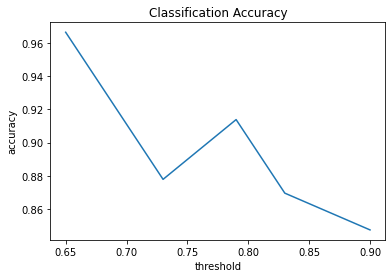

In [20]:
#print(accuracy)
# importing the required module 
import matplotlib.pyplot as plt 
print(accuracy)
print(threshold)
# plotting the points  
plt.plot(threshold, accuracy) 
  
# naming the x axis 
plt.xlabel('threshold') 
# naming the y axis 
plt.ylabel('accuracy') 
  
# giving a title to my graph 
plt.title('Classification Accuracy') 
  
# function to show the plot 
plt.show() 